In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
from collections import Counter
import seaborn as sns

In [ ]:
# Load the data
with open('/Users/shreyanakum/Documents/CS178/CS-178-Project/DATA/tfidf_data.pkl', 'rb') as f:
    tfidf_data = pickle.load(f)

X_train_tfidf = tfidf_data['X_train']
X_test_tfidf = tfidf_data['X_test']
y_train_tfidf = tfidf_data['y_train']
y_test_tfidf = tfidf_data['y_test']
vectorizer_tfidf = tfidf_data['vectorizer']

# Balanced training
if len(y_train_tfidf.shape) > 1 and y_train_tfidf.shape[1] > 1:
    y_train_tfidf = np.argmax(y_train_tfidf, axis=1)
    y_test_tfidf = np.argmax(y_test_tfidf, axis=1)

classes = np.unique(y_train_tfidf)
n_classes = len(classes)

print(Counter(y_train_tfidf))

target_samples_per_class = 7074 // n_classes

balanced_indices = []
for cls in classes:
    cls_indices = np.where(y_train_tfidf == cls)[0]
    n_samples = min(len(cls_indices), target_samples_per_class)
    np.random.seed(42)
    sampled_indices = np.random.choice(cls_indices, size=n_samples, replace=False)
    balanced_indices.extend(sampled_indices)

np.random.seed(42)
np.random.shuffle(balanced_indices)

X_train_balanced = X_train_tfidf[balanced_indices]
y_train_balanced = y_train_tfidf[balanced_indices]

print(Counter(y_train_balanced))

Original class distribution:
Counter({0: 126913, 2: 422, 4: 253, 5: 44, 3: 24})
Counter({0: 1414, 2: 422, 4: 253, 5: 44, 3: 24})


/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [33]:
# Initialize Random Forest with adjusted parameters
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced_subsample',
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

In [34]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1_weighted', n_jobs=-1)
print(f"Mean CV F1 Score: {cv_scores}")

Mean CV F1 Score: [0.51857679 0.52238394 0.52356132 0.5208572  0.52348152]


In [35]:
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred = rf_model.predict(X_test_tfidf)
y_pred_proba = rf_model.predict_proba(X_test_tfidf)
unique, counts = np.unique(y_pred, return_counts=True)

Test Accuracy: 0.9850540498198339
Test Weighted F1 Score: 0.9867571696250643
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31727
           2       0.03      0.04      0.03       101
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00        10

    accuracy                           0.99     31915
   macro avg       0.20      0.21      0.20     31915
weighted avg       0.99      0.99      0.99     31915



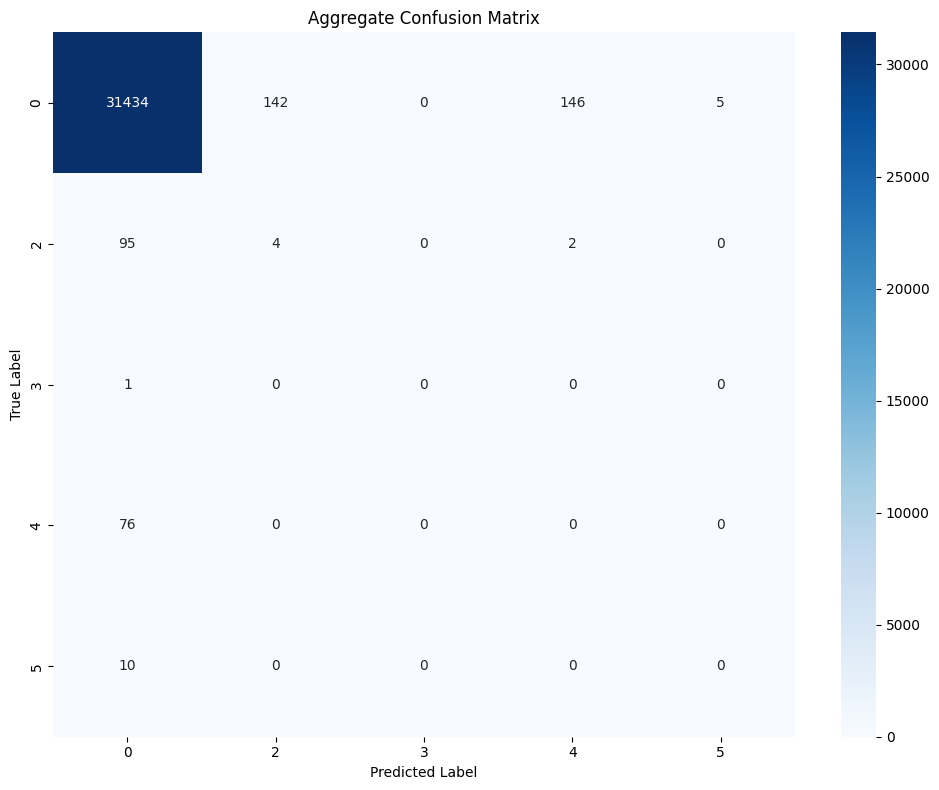

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test_tfidf, y_pred)
f1_weighted = f1_score(y_test_tfidf, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Weighted F1 Score: {f1_weighted}")

print("Classification Report")
print(classification_report(y_test_tfidf, y_pred, target_names=[str(c) for c in classes], zero_division=0))
cm = confusion_matrix(y_test_tfidf, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Aggregate Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


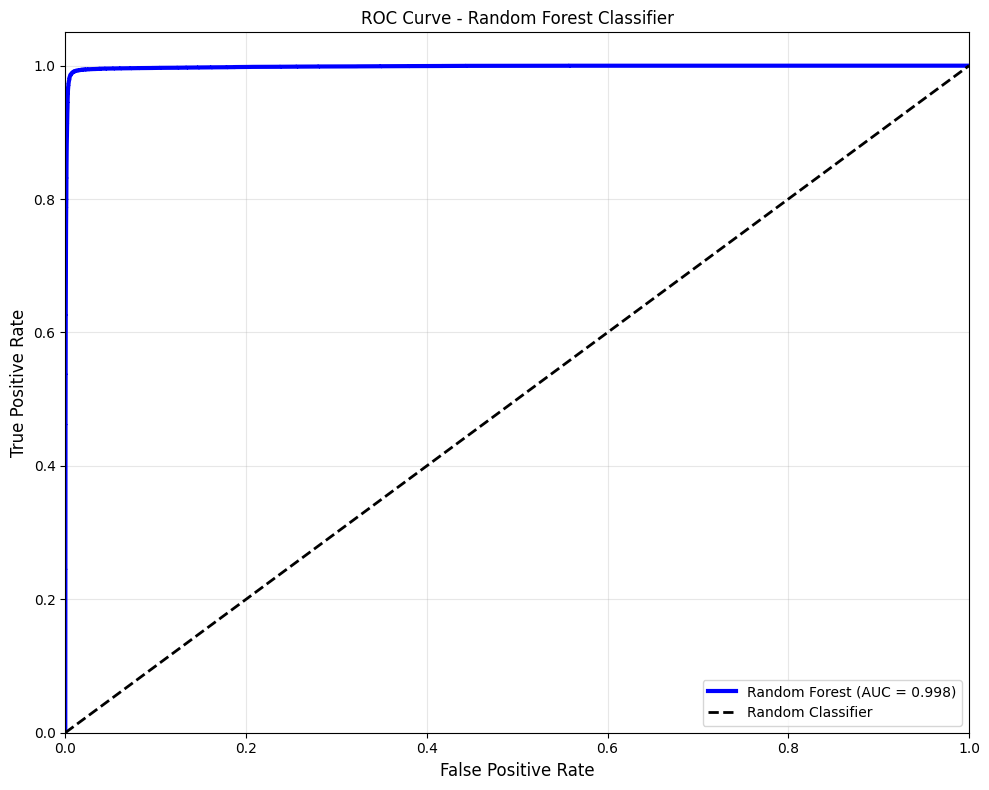


AUC Score: 0.9983123050616517


In [ ]:
# ROC Curve
y_test_bin = label_binarize(y_test_tfidf, classes=classes)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'Random Forest (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {roc_auc}")